In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import os
import random

In [ ]:
masks = pd.read_csv('/content/gdrive/MyDrive/Kaggle/train_df.csv')
masks['EncodedPixels'] = masks['EncodedPixels'].astype('string')

In [ ]:
#Getting images from train folder

def get_train_image(name: str):
    path = f'/content/gdrive/MyDrive/Kaggle/Train Image1/TI/train images 1/{name}'
    print(f'Image path: {path}')
    try:
        image = cv2.imread(path)
        if image is None:
            raise Exception("Failed to read image")
        return image
    except Exception as e:
        print(f"Error reading image: {str(e)}")
        return None

In [ ]:
#Function to plot image with encoded pixels and masked image

def show_image_with_encoded_pixels(image_id: str):
    rows = masks[masks['ImageId'] == image_id]
    if len(rows) == 0:
        return
    
    image = get_train_image(image_id)
    image_size, _, _ = image.shape
    ship_count = len(rows)
    all_ships = np.zeros_like(image)

    fig, ax = plt.subplots(ship_count + 1, 3, figsize=(15, 5 * (ship_count + 1)))

    for i in range(ship_count):
        image_info = rows.iloc[i]

        encoded_pixels = np.array(image_info['EncodedPixels'].split(), dtype=int)
        pixels, shift = encoded_pixels[::2], encoded_pixels[1::2]
        ship = np.zeros_like(image)

        for pixel, shift in zip(pixels, shift):
            for j in range(shift):
                cur_pixel = pixel + j - 1
                ship[cur_pixel % image_size, cur_pixel // image_size] = [255, 255, 255]
        all_ships += ship
        
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(ship)
        ax[i, 2].imshow(image * (ship // 255))
        
    ax[ship_count, 0].imshow(image)
    ax[ship_count, 1].imshow(all_ships)
    ax[ship_count, 2].imshow(image * (all_ships // 255))
    plt.show()


In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00


In [ ]:
#Training the UNET model

import random
import os
import tensorflow as tf
from tensorflow import keras
#Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import os
import random
# set the random seed:
RANDOM_SEED = 77
random.seed(RANDOM_SEED)

TRAIN_DIR = '/content/gdrive/MyDrive/Kaggle/Train Image1/TI/train images 1/'
TEST_DIR = '/content/gdrive/MyDrive/Kaggle/Test Image/untitled folder/Test_Merged/'
# BUFFER_SIZE = 1000
IMG_SHAPE = (256, 256)
NUM_CLASSES = 2

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Kaggle/train_df.csv")
df['EncodedPixels'] = df['EncodedPixels'].astype('string')

# Delete corrupted images
# CORRUPTED_IMAGES = ['6384c3e78.jpg']
# df = df.drop(df[df['ImageId'].isin(CORRUPTED_IMAGES)].index)

# Dataframe that contains the segmentation for each ship in the image. 
instance_segmentation = df

# Dataframe that contains the segmentation of all ships in the image.
image_segmentation = df.groupby(by=['ImageId'])['EncodedPixels'].apply(lambda x: np.nan if pd.isna(x).any() else ' '.join(x)).reset_index()

In [ ]:
def rle_to_mask(rle: str, shape=(768, 768)):
    '''
    :param rle: run length encoded pixels as string formated
           shape: (height,width) of array to return 
    :return: numpy 2D array, 1 - mask, 0 - background
    '''
    encoded_pixels = np.array(rle.split(), dtype=int)
    starts = encoded_pixels[::2] - 1
    ends = starts + encoded_pixels[1::2]
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T 

def mask_to_rle(img, shape=(768, 768)) -> str:
    """
    :param img: numpy 2D array, 1 - mask, 0 - background
           shape: (height,width) dimensions of the image 
    :return: run length encoded pixels as string formated
    """
    img = img.astype('float32')
    img = cv2.resize(img, shape, interpolation=cv2.INTER_AREA)
    img = np.stack(np.vectorize(lambda x: 0 if x < 0.1 else 1)(img), axis=1)
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

Data processing

In [ ]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a])

def load_train_image(tensor) -> tuple:
    path = tf.get_static_value(tensor).decode("utf-8")

    image_id = path.split('/')[-1]
    input_image = cv2.imread(path)
    input_image = tf.image.resize(input_image, IMG_SHAPE)
    input_image = tf.cast(input_image, tf.float32) / 255.0

    encoded_mask = image_segmentation[image_segmentation['ImageId'] == image_id].iloc[0]['EncodedPixels']
    input_mask = np.zeros(IMG_SHAPE + (1,), dtype=np.int8)
    if not pd.isna(encoded_mask):
        input_mask = rle_to_mask(encoded_mask)
        input_mask = cv2.resize(input_mask, IMG_SHAPE, interpolation=cv2.INTER_AREA)
        input_mask = np.expand_dims(input_mask, axis=2)
    one_hot_segmentation_mask = one_hot(input_mask, NUM_CLASSES)
    input_mask_tensor = tf.convert_to_tensor(one_hot_segmentation_mask, dtype=tf.float32)
    
    class_weights = tf.constant([0.0005, 0.9995], tf.float32)
    sample_weights = tf.gather(class_weights, indices=tf.cast(input_mask_tensor, tf.int32), name='cast_sample_weights')

    return input_image, input_mask_tensor, sample_weights


In [ ]:
#building the model

import keras.backend as K
import tensorflow_addons as tfa

class UNetModel:
    def __init__(self, input_shape=(128, 128, 3)):
        self._model = self._build_model(input_shape)

    @property
    def model(self) -> tf.keras.Model:
        return self._model
    
    def _build_model(self, input_shape, num_classes=NUM_CLASSES) -> tf.keras.Model:
        inputs = tf.keras.layers.Input(shape=input_shape)
        
        filters_list = [16, 32, 64]

        # apply Encoder
        encoder_outputs = self._encoder(input_shape, filters_list)(inputs)
        print(f'Encoder output tensors: {encoder_outputs}')

        # apply Decoder and establishing the skip connections
        x = self._decoder(encoder_outputs, filters_list[::-1])

        # This is the last layers of the model
        last = self._conv_blocks(num_classes, size=1)(x)
        outputs = tf.keras.activations.softmax(last)

        return tf.keras.Model(inputs=inputs, outputs=outputs)
    
    def _encoder(self, input_shape, filters_list):
        inputs = tf.keras.layers.Input(shape=input_shape)
        outputs = []

        model = tf.keras.Sequential()
        x = model(inputs)

        for filters in filters_list:
            x = self._conv_blocks(filters=filters, size=3, apply_instance_norm=True)(x)
            x = self._conv_blocks(filters=filters, size=1, apply_instance_norm=True)(x)
            outputs.append(x)
            x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

        output = self._conv_blocks(filters=128, size=3, apply_batch_norm=True, apply_dropout=False)(x)
        outputs.append(output)

        # Create the feature extraction model
        encoder = tf.keras.Model(inputs=inputs, outputs=outputs, name="encoder")
        encoder.trainable = True
        return encoder
    
    def _decoder(self, encoder_outputs, filters_list):     
        x = encoder_outputs[-1]
        for filters, skip, apply_dropout in zip(filters_list, encoder_outputs[-2::-1], [False] * 4):
            x = self._upsample_block(filters, 3)(x)
            x = tf.keras.layers.Concatenate()([x, skip])
            x = self._conv_blocks(filters, size=3, apply_batch_norm=True, apply_dropout=apply_dropout)(x)
            x = self._conv_blocks(filters, size=1, apply_batch_norm=True)(x)
        return x
    
    def _conv_blocks(self, filters, size, apply_batch_norm=False, apply_instance_norm=False, apply_dropout=False):
        """Downsamples an input. Conv2D => Batchnorm => Dropout => LeakyReLU
            :param:
                filters: number of filters
                size: filter size
                apply_dropout: If True, adds the dropout layer
            :return: Downsample Sequential Model
        """
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(
          tf.keras.layers.Conv2D(filters, size, strides=1,
                                 padding='same', use_bias=False,
                                 kernel_initializer=initializer,))
        if apply_batch_norm:
            result.add(tf.keras.layers.BatchNormalization())
        if apply_instance_norm:
            result.add(tfa.layers.InstanceNormalization())
        result.add(tf.keras.layers.Activation(tfa.activations.mish))
        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.55))
        return result
    
    def _upsample_block(self, filters, size, apply_dropout=False):
        """Upsamples an input. Conv2DTranspose => Batchnorm => Dropout => LeakyReLU
            :param:
                filters: number of filters
                size: filter size
                apply_dropout: If True, adds the dropout layer
            :return: Upsample Sequential Model
        """
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(
          tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          use_bias=False))
        result.add(tf.keras.layers.BatchNormalization())
        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.1))
        result.add(tf.keras.layers.Activation(tfa.activations.mish))
        return result
    

In [ ]:
# Load a pretrained Resnet50 model and finetune.

from keras.layers.convolutional.conv2d_transpose import Conv2DTranspose
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from keras.layers import Dense, Conv2D, Flatten, UpSampling2D
from keras.models import Model

#load pretrained resnet 50 for feature extraction
resnet_model = ResNet50(weights='imagenet', include_top=False,input_shape=IMG_SHAPE + (3,))
for layer in resnet_model.layers:
    layer.trainable = False

resnet_out = resnet_model.get_layer("conv1_relu").output
conv_1= Conv2D(3, (1, 1), activation='relu')(resnet_out)
unet_input = UpSampling2D(size=(2, 2))(conv_1)
umodel = UNetModel(IMG_SHAPE + (3,)).model
print(umodel.summary())
unet_output = umodel(unet_input)
final_resnet_model = Model(inputs=resnet_model.input, outputs=unet_output)



94765736/94765736 [==============================] - 0s 0us/step
Encoder output tensors: [<KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'encoder')>, <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'encoder')>, <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'encoder')>, <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'encoder')>]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           [(None, 256, 256, 1  103536

In [ ]:
#Defining Losses

def dice(targets, inputs, smooth=1e-6):
    axis = [1,2,3]
    intersection = K.sum(targets * inputs, axis=axis)
    dice = (2 * intersection + smooth) / (K.sum(targets, axis=axis) + K.sum(inputs, axis=axis) + smooth)
    return dice

def bce_loss(targets, inputs, smooth=1e-6):
    axis = [1,2,3]
    loss = K.sum(targets * tf.math.log(inputs + smooth) + (1 - targets) * tf.math.log(1 - inputs + smooth), axis=axis)
    return - loss

def bce_dice_loss(targets, inputs):
    return bce_loss(targets, inputs) - tf.math.log(dice(targets, inputs))

In [ ]:
#Building IOU metric class

class IoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes: int, target_class_ids: list, sparse_y_true: bool, sparse_y_pred: bool,
                 axis: int = -1, name=None, dtype=None):
        super(IoU, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.target_class_ids = target_class_ids
        self.sparse_y_true = sparse_y_true
        self.sparse_y_pred = sparse_y_pred
        self.axis = axis

        # Variable to accumulate the predictions in the confusion matrix.
        self.total_cm = self.add_weight(
            'total_confusion_matrix',
            shape=(num_classes, num_classes),
            initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Accumulates the confusion matrix statistics.
        Args:
          y_true: The ground truth values.
          y_pred: The predicted values.
          sample_weight: Optional weighting of each example. Defaults to 1. Can be a
            `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
            be broadcastable to `y_true`.
        Returns:
          Update op.
        """
        
        y_true = tf.reshape(y_true, [-1] + list(y_pred.shape[1:]))
        
        if not self.sparse_y_true:
            y_true = tf.argmax(y_true, axis=self.axis)
        if not self.sparse_y_pred:
            y_pred = tf.argmax(y_pred, axis=self.axis)
            
        y_true = tf.cast(y_true, self._dtype)
        y_pred = tf.cast(y_pred, self._dtype)

        # Flatten the input if its rank > 1.
        if y_pred.shape.ndims > 1:
            y_pred = tf.reshape(y_pred, [-1])

        if y_true.shape.ndims > 1:
            y_true = tf.reshape(y_true, [-1])

        if sample_weight is not None:
            sample_weight = tf.reshape(sample_weight, [-1, 128, 128])
            sample_weight = tf.cast(sample_weight, self._dtype)
            if sample_weight.shape.ndims > 1:
                sample_weight = tf.reshape(sample_weight, [-1])

        # Accumulate the prediction to current confusion matrix.
        current_cm = tf.math.confusion_matrix(y_true, y_pred, self.num_classes, weights=sample_weight, dtype=self._dtype)
        return self.total_cm.assign_add(current_cm)
    
    def reset_state(self):
        tf.keras.backend.set_value(
            self.total_cm, np.zeros((self.num_classes, self.num_classes))
        )
    
    def result(self):
        """Compute the intersection-over-union via the confusion matrix."""
        sum_over_row = tf.cast(
            tf.reduce_sum(self.total_cm, axis=0), dtype=self._dtype)
        sum_over_col = tf.cast(
            tf.reduce_sum(self.total_cm, axis=1), dtype=self._dtype)
        true_positives = tf.cast(
            tf.linalg.tensor_diag_part(self.total_cm), dtype=self._dtype)

        # sum_over_row + sum_over_col = 2 * true_positives + false_positives + false_negatives.
        denominator = sum_over_row + sum_over_col - true_positives

        # Only keep the target classes
        true_positives = tf.gather(true_positives, self.target_class_ids)
        denominator = tf.gather(denominator, self.target_class_ids)

        # If the denominator is 0, we need to ignore the class.
        num_valid_entries = tf.reduce_sum(
            tf.cast(tf.not_equal(denominator, 0), dtype=self._dtype))

        iou = tf.math.divide_no_nan(true_positives, denominator)

        return tf.math.divide_no_nan(
            tf.reduce_sum(iou, name='mean_iou'), num_valid_entries)
    
    def get_config(self):
        config = {
            "num_classes": self.num_classes,
            "target_class_ids": self.target_class_ids,
            "sparse_y_true": self.sparse_y_true,
            "sparse_y_pred": self.sparse_y_pred,
            "axis": self.axis,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
import os
IMAGES_WITHOUT_SHIPS_NUMBER = 20000

# reduce the number of images without ships for balancing the data
images_without_ships = image_segmentation[image_segmentation['EncodedPixels'].isna()]['ImageId'].values[:IMAGES_WITHOUT_SHIPS_NUMBER]
images_with_ships = image_segmentation[image_segmentation['EncodedPixels'].notna()]['ImageId'].values
images_list = np.append(images_without_ships, images_with_ships)


images_list = os.listdir(TRAIN_DIR)[0: 24000]
images_list_test = os.listdir(TRAIN_DIR)[0: 24000]
testpath = TRAIN_DIR

images_list_testing = images_list[0:1000]
VALIDATION_LENGTH = 3200
TEST_LENGTH = 3200
TRAIN_LENGTH = len(images_list) - VALIDATION_LENGTH - TEST_LENGTH
BATCH_SIZE = 16

EPOCHS = 10
#STEPS_PER_EPOCH = 150
STEPS_PER_EPOCH = 1100
validation_steps = 100
print(TRAIN_LENGTH)


17600


In [ ]:
images_list = tf.data.Dataset.list_files([f'{TRAIN_DIR}{name}' for name in images_list], shuffle=True)
train_images = images_list.map(lambda x: tf.py_function(load_train_image, [x], [tf.float32, tf.float32]), num_parallel_calls=tf.data.AUTOTUNE)

validation_dataset = train_images.take(VALIDATION_LENGTH)
test_dataset = train_images.skip(VALIDATION_LENGTH).take(TEST_LENGTH)
train_dataset = train_images.skip(VALIDATION_LENGTH + TEST_LENGTH)

train_batches = (train_dataset.repeat().batch(BATCH_SIZE))

validation_batches = validation_dataset.batch(BATCH_SIZE)
#validation_batches = (validation_dataset.repeat().batch(BATCH_SIZE))

test_batches = test_dataset.batch(BATCH_SIZE)

#test_batches = (test_dataset.repeat().batch(BATCH_SIZE))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Trainable params: 303091


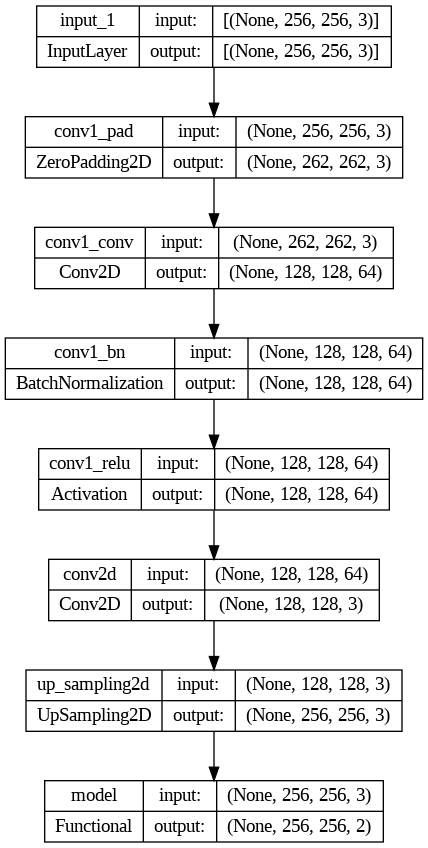

In [ ]:



optimizer = tfa.optimizers.RectifiedAdam(
    learning_rate=0.005,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_proportion=0.3,
    min_lr=0.00001,
)
optimizer = tfa.optimizers.Lookahead(optimizer)

loss = tf.keras.losses.CategoricalCrossentropy()
mIoU = IoU(num_classes=2, target_class_ids=[0, 1], sparse_y_true=False, sparse_y_pred=False, name='mean-IoU')

# model = UNetModel(IMG_SHAPE + (3,)).model
final_resnet_model.compile(optimizer=optimizer, 
              loss=loss, # bce_dice_loss,
              metrics=[mIoU, 'binary_accuracy'] ) 

trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in final_resnet_model.trainable_variables])
print(f'Trainable params: {trainable_params}')

tf.keras.utils.plot_model(final_resnet_model, show_shapes=True)


In [ ]:
import cv2

checkpoint_filepath = '/content/gdrive/MyDrive/Kaggle/checkpoints/model-checkpoint'
save_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mean-IoU',
    mode='max',
    save_best_only=True
)

early_stop_callback = keras.callbacks.EarlyStopping(
    monitor='val_mean-IoU',
    mode='max',
    patience= 2,
    restore_best_weights=True
)


In [ ]:


model_history = final_resnet_model.fit(train_batches,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=validation_batches,
                          validation_steps=validation_steps,
                          callbacks=[save_callback, early_stop_callback])
final_resnet_model.load_weights(checkpoint_filepath)

Epoch 1/10
1100/1100 [==============================] - ETA: 0s - loss: 0.4479 - mean-IoU: 0.4899 - binary_accuracy: 0.9742

1100/1100 [==============================] - 1057s 798ms/step - loss: 0.4479 - mean-IoU: 0.4899 - binary_accuracy: 0.9742 - val_loss: 0.0782 - val_mean-IoU: 0.5006 - val_binary_accuracy: 0.9988
Epoch 2/10
1100/1100 [==============================] - ETA: 0s - loss: 0.0452 - mean-IoU: 0.5674 - binary_accuracy: 0.9988

1100/1100 [==============================] - 916s 806ms/step - loss: 0.0452 - mean-IoU: 0.5674 - binary_accuracy: 0.9988 - val_loss: 0.0309 - val_mean-IoU: 0.6751 - val_binary_accuracy: 0.9989
Epoch 3/10
1100/1100 [==============================] - ETA: 0s - loss: 0.0114 - mean-IoU: 0.6371 - binary_accuracy: 0.9990

1100/1100 [==============================] - 902s 790ms/step - loss: 0.0114 - mean-IoU: 0.6371 - binary_accuracy: 0.9990 - val_loss: 0.0049 - val_mean-IoU: 0.6850 - val_binary_accuracy: 0.9992
Epoch 4/10
 810/1100 [=====================>........] - ETA: 2:59 - loss: 0.0050 - mean-IoU: 0.6476 - binary_accuracy: 0.9990

In [ ]:
#retrain from epoch 4
final_resnet_model.load_weights(checkpoint_filepath)
model_history_2 = final_resnet_model.fit(train_batches,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=validation_batches,
                          validation_steps=validation_steps,
                          callbacks=[save_callback, early_stop_callback])


Epoch 1/10
1100/1100 [==============================] - ETA: 0s - loss: 0.0039 - mean-IoU: 0.6520 - binary_accuracy: 0.9990

1100/1100 [==============================] - 957s 649ms/step - loss: 0.0039 - mean-IoU: 0.6520 - binary_accuracy: 0.9990 - val_loss: 0.0030 - val_mean-IoU: 0.7168 - val_binary_accuracy: 0.9991
Epoch 2/10
1100/1100 [==============================] - 347s 316ms/step - loss: 0.0031 - mean-IoU: 0.6807 - binary_accuracy: 0.9991 - val_loss: 0.0026 - val_mean-IoU: 0.7003 - val_binary_accuracy: 0.9993
Epoch 3/10
1100/1100 [==============================] - ETA: 0s - loss: 0.0029 - mean-IoU: 0.6996 - binary_accuracy: 0.9992

1100/1100 [==============================] - 498s 392ms/step - loss: 0.0029 - mean-IoU: 0.6996 - binary_accuracy: 0.9992 - val_loss: 0.0028 - val_mean-IoU: 0.7240 - val_binary_accuracy: 0.9992
Epoch 4/10
1100/1100 [==============================] - ETA: 0s - loss: 0.0026 - mean-IoU: 0.7167 - binary_accuracy: 0.9992

1100/1100 [==============================] - 433s 394ms/step - loss: 0.0026 - mean-IoU: 0.7167 - binary_accuracy: 0.9992 - val_loss: 0.0025 - val_mean-IoU: 0.7314 - val_binary_accuracy: 0.9992
Epoch 5/10
1100/1100 [==============================] - ETA: 0s - loss: 0.0025 - mean-IoU: 0.7298 - binary_accuracy: 0.9993

1100/1100 [==============================] - 434s 395ms/step - loss: 0.0025 - mean-IoU: 0.7298 - binary_accuracy: 0.9993 - val_loss: 0.0024 - val_mean-IoU: 0.7661 - val_binary_accuracy: 0.9993
Epoch 6/10
1100/1100 [==============================] - 343s 312ms/step - loss: 0.0022 - mean-IoU: 0.7500 - binary_accuracy: 0.9993 - val_loss: 0.0021 - val_mean-IoU: 0.7346 - val_binary_accuracy: 0.9994
Epoch 7/10
1100/1100 [==============================] - ETA: 0s - loss: 0.0021 - mean-IoU: 0.7591 - binary_accuracy: 0.9994

1100/1100 [==============================] - 505s 398ms/step - loss: 0.0021 - mean-IoU: 0.7591 - binary_accuracy: 0.9994 - val_loss: 0.0017 - val_mean-IoU: 0.7808 - val_binary_accuracy: 0.9995
Epoch 8/10
1100/1100 [==============================] - ETA: 0s - loss: 0.0020 - mean-IoU: 0.7645 - binary_accuracy: 0.9994

1100/1100 [==============================] - 437s 398ms/step - loss: 0.0020 - mean-IoU: 0.7645 - binary_accuracy: 0.9994 - val_loss: 0.0019 - val_mean-IoU: 0.7819 - val_binary_accuracy: 0.9994
Epoch 9/10
1100/1100 [==============================] - 331s 301ms/step - loss: 0.0020 - mean-IoU: 0.7626 - binary_accuracy: 0.9994 - val_loss: 0.0022 - val_mean-IoU: 0.7368 - val_binary_accuracy: 0.9993
Epoch 10/10
1100/1100 [==============================] - 415s 316ms/step - loss: 0.0020 - mean-IoU: 0.7670 - binary_accuracy: 0.9994 - val_loss: 0.0020 - val_mean-IoU: 0.7615 - val_binary_accuracy: 0.9994


In [ ]:
# model.save('/content/gdrive/MyDrive/Kaggle/saved_models/new_model/model.h5')

# from tensorflow.keras.models import load_model

# newmodel = load_model('/content/gdrive/MyDrive/Kaggle/saved_models/new_model/model.h5')

In [ ]:
#Generating table for epoch values

epochs = range(1, len(model_history_2.history['loss'])+1)
pd.DataFrame(model_history_2.history, index=epochs)

,loss,mean-IoU,binary_accuracy,val_loss,val_mean-IoU,val_binary_accuracy
1,0.003884,0.652018,0.999030,0.003033,0.716797,0.999133
2,0.003093,0.680713,0.999145,0.002572,0.700344,0.999252
3,0.002881,0.699632,0.999176,0.002845,0.724050,0.999195
4,0.002578,0.716707,0.999239,0.002464,0.731427,0.999249
5,0.002474,0.729767,0.999257,0.002388,0.766140,0.999267
6,0.002213,0.749996,0.999324,0.002053,0.734613,0.999366
7,0.002058,0.759059,0.999356,0.001669,0.780775,0.999473
8,0.001965,0.764491,0.999385,0.001897,0.781913,0.999429
9,0.002046,0.762648,0.999353,0.002215,0.736765,0.999288
10,0.001979,0.767046,0.999375,0.001974,0.761473,0.999374


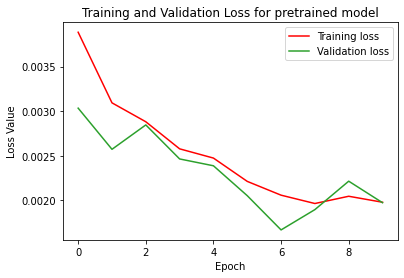

In [ ]:
loss = model_history_2.history['loss']
val_loss = model_history_2.history['val_loss']

plt.figure()
plt.plot(model_history_2.epoch, loss, 'r', label='Training loss')
plt.plot(model_history_2.epoch, val_loss, 'C2', label='Validation loss')
plt.title('Training and Validation Loss for pretrained model')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

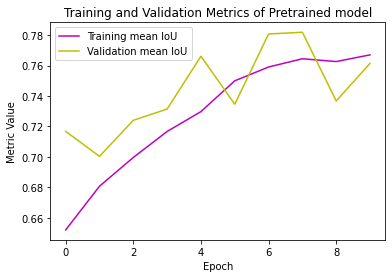

In [ ]:
mIoU = model_history_2.history['mean-IoU']
val_mIoU = model_history_2.history['val_mean-IoU']

plt.figure()
plt.plot(model_history_2.epoch, mIoU, 'm', label='Training mean IoU')
plt.plot(model_history_2.epoch, val_mIoU, 'y', label='Validation mean IoU')

plt.title('Training and Validation Metrics of Pretrained model')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [ ]:
results = final_resnet_model.evaluate(test_batches)
print("test loss, test mIoU:", results)

200/200 [==============================] - 97s 246ms/step - loss: 0.0019 - mean-IoU: 0.7821 - binary_accuracy: 0.9994
test loss, test mIoU: [0.0018670615972951055, 0.7821391820907593, 0.9994120001792908]


In [ ]:
#Defining predict

def predict(image):
    image = np.expand_dims(image, axis=0)
    pred_mask = final_resnet_model.predict(image)[0].argmax(axis=-1)  
    return pred_mask

1/1 [==============================] - 0s 26ms/step


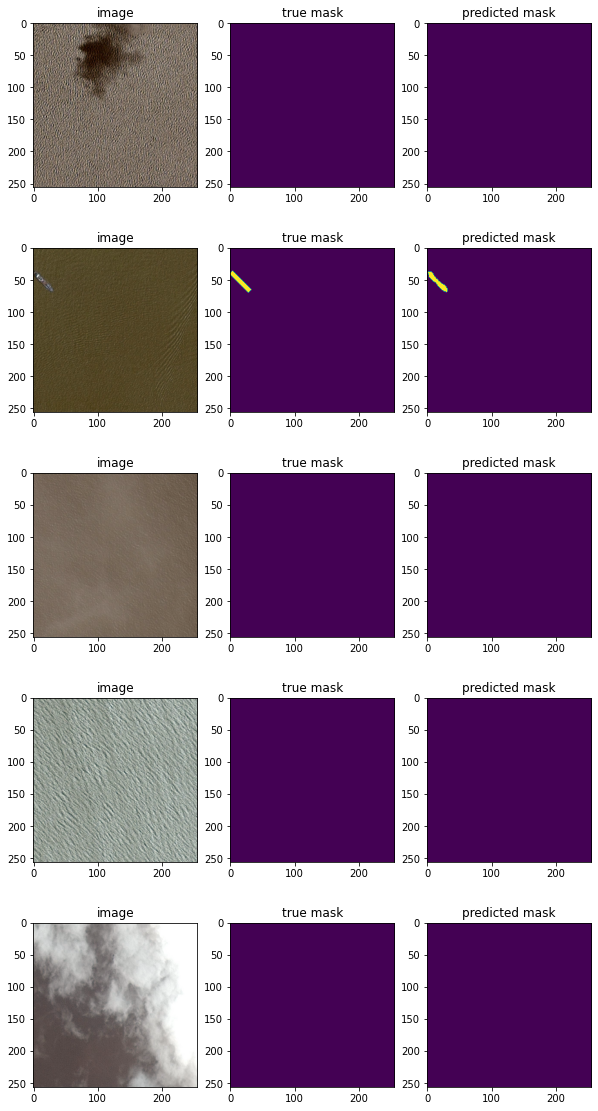

In [ ]:
N = 5

f,ax = plt.subplots(N, 3, figsize=(10, 4 * N))
i = 0
for image, mask in test_dataset.take(N):
    mask = mask.numpy().argmax(axis=-1)
    ax[i, 0].imshow(image)
    ax[i, 0].set_title('image')
    ax[i, 1].imshow(mask)
    ax[i, 1].set_title('true mask')

    pred_mask = predict(image)
    ax[i, 2].imshow(pred_mask)
    ax[i, 2].set_title('predicted mask')
    i += 1

plt.show()